# Digital recognizer
importation of the training dataframe

In [12]:
# python librairies
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

Some maths function for the linear regression

In [13]:
def Phi0(xi):
    return 1

def Phik(xi, k):
    return xi[k]

def sigmoid(x):
    sig =  1/(1 + np.exp(-x))
    sig = np.maximum(0.00001, sig)                       
    sig = np.minimum(0.99999, sig)                       # saturation to avoid the 1 that causes log problem
    return sig

Creation of a logistic regression classe

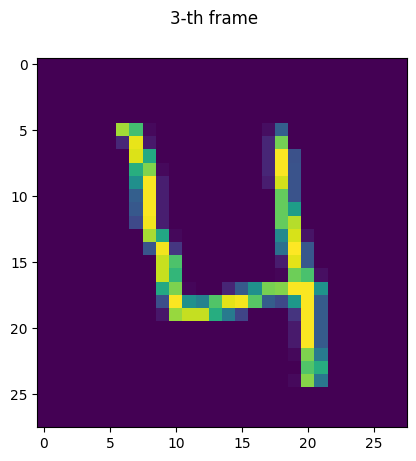

In [14]:
class LogisticRegression:

    # data relative attributs
    frame_height_pxl = 28
    frame_width_pxl = 28
    nb_frames = 0
    nb_pxls = frame_height_pxl*frame_width_pxl
    nb_params = nb_pxls +1                                      # one parameter per pixel + the bias => nb_pxls + 1 parameters to optimize 
    X = None
    
    # model relative attributs
   

    # optimization relative attributs
    Theta = np.empty( (nb_params,1) )                           # column vector of parameters to optimize
    alpha = 0.00005
    nb_it = 100                                                 # number of iteration

    # user choice relative attributs 
    targeted_digit_number = 4                                   # as an example, could also be 1 or 2 ... or 9

    # training data relative attributs
    csv_train_data_filepath = None                              # file containing the raw datas 
    train_data= None                                            # matrix array containing all the pixels of each frame
    y = None                                                    # column vector containing the output of each frame


    # constructor
    def __init__(self, csv_train_data_filepath, digit = 4):
        self.csv_train_data_filepath = csv_train_data_filepath          
        df_train = pd.read_csv(csv_train_data_filepath)          # reading the csv file containing all the training data
        df_train = df_train[0:1000]                              # just keeping the 1000 first frame to enlight the computation
        self.nb_frames = df_train.shape[0]                       # one frame per row
        self.X = np.empty( (self.nb_frames, self.nb_params) )
        self.targeted_digit_number = digit

        # outputs vector
        self.y = np.array(df_train['label'])                     # reading the label column
        self.y = (self.y).reshape( ( (self.y).shape[0],1) )      # reshaping for more explicit dimensions
        self.y[self.y != self.targeted_digit_number] = 0.0       # the output of the non corresponding digit frame put to 0
        self.y[self.y == self.targeted_digit_number] = 1.0       # the output of the corresponding digit frame put to 1

        # data matrix
        df_train = df_train.drop('label', axis = 1)              # remove the column containg the y values, we specifie the axis so that pandas know where to look for 'label'
        self.train_data= df_train.to_numpy()                     # nb_frames * nb_pxls matrix containg all the trainig data

        
        self.InitializeTheta()
        self.ComputeX()                                          # X is constant through iteration we can then build it since the construction of the object




    # This method display the digit of the ind-th frame.
    def DisplayDigit(self,frame_index):
        Z = self.train_data[frame_index,:]                       # acces based on the index

        Frame1 = np.array(Z)
        Frame1 = Frame1.reshape((self.frame_height_pxl, self.frame_width_pxl))

        fig = plt.figure()
        im = plt.imshow(Frame1)
        fig.suptitle(f'{frame_index}-th frame')



    # The X matrix contain the value of all the subpart of the model on each column and for all frame in each row
    def ComputeX(self):
        for row in range(self.nb_frames):                         # on balaye chaque ligne du dataframe
            xi = self.train_data[row,:]
            xi = xi.reshape ( (xi.shape[0],1) )                                        
            self.X[row,0] = Phi0(xi)                                  
            for col in range(1, self.nb_params):
                self.X[row,col] = Phik(xi,col-1)                  # (col-1) parce que 1 parametre de plus que de nb de pixel (le parametre constant)
        
    
    # return the value of all the subpart of a model for a given point
    def GetPhiVec(self,xi):
        Phi_vec = np.empty( (self.nb_params,1))
        
        Phi_vec[0] = Phi0(xi)                                     # bias
        for i in range(1,self.nb_pxls):
            Phi_vec[i] = Phik(xi,i)
        
        return Phi_vec
    


    def InitializeTheta(self):
        Theta0 = 20*np.random.rand(self.nb_params,1)
        self.Theta = Theta0


    def ComputeDecisionVec(self):
        decision_vec = np.empty( (self.nb_frames,1))
        for i in range(self.nb_frames):

            # reading and extracting the i-th row of the data frame
            xi = self.train_data[i,:]
            xi = xi.reshape( (xi.shape[0],1) )

            Phi_vec = self.GetPhiVec(xi)

            decision_vec[i] = sigmoid( np.matmul( np.transpose(self.Theta),Phi_vec ) )
        
        return decision_vec

    def ComputeCost(self):
        decision_vec = self.ComputeDecisionVec()
        J = -sum(self.y * np.log(decision_vec) + (1-self.y) * np.log(1 - decision_vec))
        return J
    


    def ComputeGrad(self):
        X_t = np.transpose( self.X )
        decision_vec = self.ComputeDecisionVec()
        grad = np.matmul( X_t, (decision_vec - self.y))
        return grad
    
    def ComputenextStep(self):
        grad_i = self.ComputeGrad()
        self.Theta = self.Theta -self.alpha*grad_i



    def TrainModel(self):

        # computaing
        cost = np.empty( (self.nb_it,1) )
        for i in range(self.nb_it):
            self.ComputenextStep()
            
            cost[i] = self.ComputeCost()
            if i%10 == 0:
                print(f'epoch : {i}, cost = {cost[i]}')


        # plotting
        import matplotlib.animation as animation

        fig, ax = plt.subplots()
        ax.set_title("Cost")
        ax.set_xlabel("iterations")

        def animate(i):
            ax.plot(range(i),cost[0:i],'b-')
        
        anim = animation.FuncAnimation(fig, animate, frames = self.nb_it, interval = 100, repeat = False)
        anim.save('figures/cost_evolution.gif')
        plt.show()

        

        return self.Theta
    

    # Testing the model
    def TestModelOnTrainingData(self):
        decision_vec = self.ComputeDecisionVec()
        correct_prediction_counter = 0
        for i in range(self.nb_frames):
            if ( ( (decision_vec[i]>0.9)&(self.y[i] == 1) ) | ( (decision_vec[i]< 0.1)&(self.y[i]==0) ) ):
                correct_prediction_counter += 1
        
        return (correct_prediction_counter/self.nb_frames)
    

        
MyLogisticregression = LogisticRegression('./train/train.csv')
MyLogisticregression.DisplayDigit(frame_index = 3)
        

epoch : 0, cost = [10338.60808755]


/tmp/ipykernel_9654/2861814117.py:8: RuntimeWarning: overflow encountered in exp
  sig =  1/(1 + np.exp(-x))


epoch : 10, cost = [1358.53402491]
epoch : 20, cost = [1001.6336455]
epoch : 30, cost = [840.45282899]
epoch : 40, cost = [703.70020508]
epoch : 50, cost = [748.34950527]
epoch : 60, cost = [679.27201248]
epoch : 70, cost = [644.73326609]
epoch : 80, cost = [587.16868876]
epoch : 90, cost = [564.14285783]


MovieWriter ffmpeg unavailable; using Pillow instead.


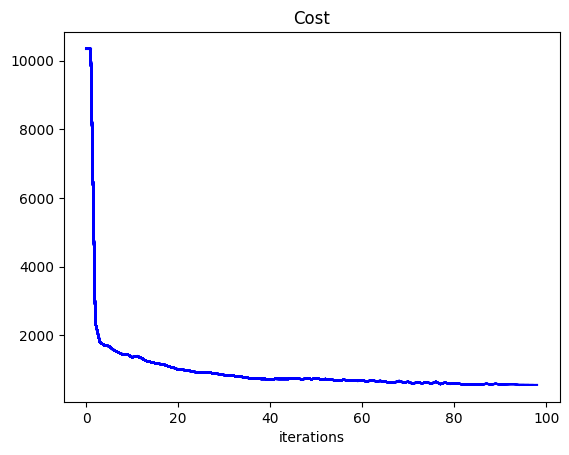

/tmp/ipykernel_9654/2861814117.py:8: RuntimeWarning: overflow encountered in exp
  sig =  1/(1 + np.exp(-x))


correct prediction = 95.1 %


In [15]:


def main():
    Logisticregression4 = LogisticRegression('./train/train.csv',4)
    Theta_opt = Logisticregression4.TrainModel()
    correctness_pred = Logisticregression4.TestModelOnTrainingData()
    print(f'correct prediction = {correctness_pred*100} %')


if __name__ == "__main__":
    main()    

